In [1]:
# Import libraries to use 
import numpy as np
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings
import string
import pandas as pd

In [2]:
def readdata(filename,Labels,Data_points):
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    # This saves output data in txt file
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
    
    # We get the data into an array 
    fill = np.zeros (len(Labels), dtype=int)
    
    f = open (name, 'r');
    src = []
    while True:  
        line = f.readline()
        if not line: break  # end of file
        if line[0] == '#':
            continue # treat next line
        src.append(line)

    #print(src)
    data = np.zeros ([Data_points, len(Labels)])

    for line in src:
        #print line
        # Here we initialize the ngspice data array
        '''
        if line.startswith('No.'):
            temp_list = line.split(":")
            Data_points = int(temp_list[-1])
            #print(Data_points)
            data = np.zeros ([Data_points, len(Labels)])
            #print(data.shape)
        '''
        
        
        # Here we determine the indexes for the current columns
        if line.startswith('Index'):
            temp_list = [str(x) for x in line.split()]
            #print(temp_list)
            n_columns = len (temp_list)
            index = np.zeros(n_columns, dtype = int)

            for j in range(n_columns):
                index [j] = Labels.index(temp_list[j])
            #print index

        # if the line starts with a number, we treat it as the data line
        if line[0].isdigit():
            temp_data = [float(x) for x in line.split()]

            for c in range(n_columns):
                r = fill[c]
                #print(r, index [c])

                data [r][index[c]] = temp_data [c]

                fill [c] = fill [c] + 1
                if fill [c] == Data_points:
                    fill [c] = 0
    return data

In [11]:
# Definition to generate netlist for an arbitraty number of sections

def generatingnetlist(filename,ns,ntapes,Ic,n,Rc,Imax,Rt):
    
    nodes = ((ns+1)*ntapes)+1 # Number of nodes
    num_rc = (ns+1)*(ntapes-1) # Total Number of contact resistances
    # Printing the labels of the elements to read current for this case
    Labels = ['Index','i-sweep']
    
    # Voltage in nodes
    for i in range(nodes):
        Labels.append(f'v({i+1})')
    # Contact resistances
    for i in range(num_rc):
        Labels.append(f'@r{i+1}[i]')
    # Voltage sources
    for i in range(ntapes):
        for j in range(ns):
            Labels.append(f'@b_{i+1}_{j+1}[i]')

    probe = ''
    for i in range(len(Labels)-2):
        probe = probe + Labels[i+2]+' '
    #print(probe)
    
    # Patameters for the model
    #Rt = 5E-7 # Terminal resistance
    #Rt = 2.6E-6 # From measurements
    #n = 30 # n-value
    Ec = 100E-6 # Electric field criterion
    L = 0.17 # [m] length of tape
    Vc = Ec*L
    #Imax = 250 # Maximum current
    step = 1 # Step current
    Data_points = int(Imax/step + 1)

    # Start writing netlist
    with open(filename, 'w') as output:
        output.write(f'* Netlist for 2 tapes with contact resistance\n')
        output.write('I1 0 1 100\n') # Current source

        # Terminal resistances
        for i in range(ntapes):
            output.write(f'rt_i_{i+1} 1 {2+(ns+1)*i} {Rt/2}\n')
            output.write(f'rt_f_{i+1} {((ns+1)*(i+1))+1} 0 {Rt/2}\n')
        # Contact resistances
        for i in range(num_rc):
            output.write(f'r{i+1} {ns+3+i} {i+2} {Rc[i]}\n')

        # Voltage sources
        for i in range(ntapes):
            for j in range(ns):
                output.write(f'b_{i+1}_{j+1} {2+(ns+1)*i+j} {3+(ns+1)*i+j} V={Vc/ns}*pow((I(b_{i+1}_{j+1})/{Ic[i,j]}),{n[i,j]})\n')
        
        output.write('.options savecurrents\n')
        output.write(f'.dc I1 0 {Imax} 1\n')
        output.write('.print dc '+probe+'\n')
        output.write('.end\n')
    return Labels,Data_points
        

In [4]:
# Fitting model including resistance 
def model_func(I,Rt,Ic,n):
    V0 = 100E-6 # Considering the criterion 100uV/m with length = 1 m
    return Rt*I+V0*(I/Ic)**n

def fit_exp(I,V,Rt0,Ic0,n0): #(Rt0,Ic0,n0) are guessed initial values 
    opt_parms, parm_cov = sp.optimize.curve_fit(model_func, I, V,(Rt0,Ic0,n0))
    Rt,Ic,n = opt_parms
    return Rt,Ic,n

# Analizing two tapes cable with a defect in a 3-section model

- Average Ic and n value of all superconducting voltage sources is 95.13 A and 32.45, respectively.
- The defect is on tape 2 at the center. Ic and n value are 40 A and 16.
* These values are obtained from measurement.
- Length of the tape 10 cm. 

<img src="2tapesdefect.png">

### Plotting experimental data and fitting to the power law model with terminatuib resistance.

Rc: Rt = 1.2491e-06, Ic = 213.6112, n = 8.2225, Fit-error = 1.32136e-05



<IPython.core.display.Javascript object>


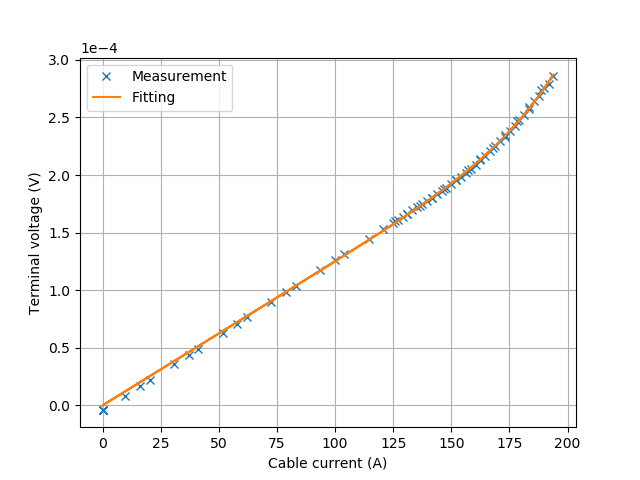

In [10]:
%matplotlib notebook

# Exponential fitting
Rt0,Ic0,n0 = 0.5E-6,100,30 # Initial values to fit exponential part
Rt_e,Ic_e,n_e = fit_exp(Icable_m,voltages[0],Rt0,Ic0,n0)
#print(Rt_e,Ic_e,n_e)

# Getting curve from fitting 
Vt_fit_exp = model_func(Icable_m,Rt_e,Ic_e,n_e)

# Calculating fitting error
Error = np.sqrt(sum((voltages[0]-Vt_fit_exp)**2))

# Plotting
print(f'Rc: Rt = {round(Rt_e,10)}, Ic = {round(Ic_e,4)}, n = {round(n_e,4)}, Fit-error = {round(Error,10)}\n')

plt.plot(Icable_m,voltages[0],'x',label = 'Measurement')
plt.plot(Icable_m,Vt_fit_exp,label = 'Fitting')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Cable current (A)')
plt.ylabel('Terminal voltage (V)')
#plt.title('Terminal voltage')
#plt.ylim(0,100E-6)
#plt.xlim(0,200)
plt.grid()
plt.legend()
plt.show()
#plt.savefig(f'Plots/1-Terminal voltage.png',dpi=300)

Ic
 [[133.1 130.5 131.6]
 [132.2  89.4 133.1]]
n
 [[29.2 28.5 28.1]
 [30.5 24.2 31. ]]
Rt 2.4974160637911393e-06
Imax = 195
Rc 10000.0: Rt = 1.2483e-06, Ic = 224.6192, n = 16.5503, Fit-error = 1.0467e-06



<IPython.core.display.Javascript object>


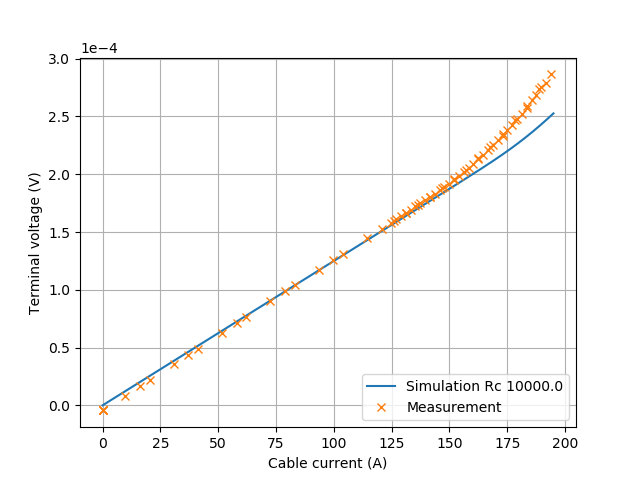

In [13]:
%matplotlib notebook
ntapes = 2
ns = 3
num_rc = (ns+1)*(ntapes-1)

Ic = [[133.1,130.5,131.6],[132.2,89.4,133.1]]
Ic = np.array(Ic)

n = [[29.2,28.5,28.1],[30.5,24.2,31]]
n = np.array(n)
print('Ic\n',Ic)
print('n\n',n)


#Termination resistance
Rt = Rt_e*2
print (f'Rt {Rt}')
Imax = 195
print(f'Imax = {Imax}')

R_cvals = np.array([1E4])

for i in range(len(R_cvals)):
    filename = f'2 tapes/2 tapes - Rc {R_cvals[i]}.cir'
    Rc = np.zeros(num_rc)+R_cvals[i]

    Labels, Data_points = generatingnetlist(filename,ns,ntapes,Ic,n,Rc,Imax,Rt)

    data = readdata(filename,Labels,Data_points)
    
    Icable = data[:,1]
    Vt = data[:,2]
    #plt.plot(Icable,Vt,label = f'Rc {Rc[i]}')
    #plt.show()
    
    Vt_lim = []
    Icable_lim = []
    # Voltage limit
    for l in range(len(Vt)):
        if Vt[l] <= 1000e-6: # Limit of the total voltage
            Vt_lim.append(Vt[l])
            Icable_lim.append(Icable[l])
    
    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
    
    # Exponential fitting
    Rt0,Ic0,n0 = 0.5E-6,100,30 # Initial values to fit exponential part
    Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
    #print(Rt_e,Ic_e,n_e)

    # Getting curve from fitting 
    Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

    # Calculating fitting error
    Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))

    # Plotting
    print(f'Rc {R_cvals[i]}: Rt = {round(Rt_e,10)}, Ic = {round(Ic_e,4)}, n = {round(n_e,4)}, Fit-error = {round(Error,10)}\n')
    plt.plot(Icable_lim,Vt_lim,label = f'Simulation Rc {R_cvals[i]}')
    #plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rc {R_cvals[i]}')
    #plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rc {Rc[i]} 3S')
    #plt.plot(data[:,1],data[:,2],label = Labels[2]+f'{ns} sections- Rc {R_cvals[i]}')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Cable current (A)')
plt.ylabel('Terminal voltage (V)')
#plt.title('Terminal voltage')
#plt.ylim(0,100E-6)
#plt.xlim(0,200)
plt.grid()
plt.legend()
plt.show()
#plt.savefig(f'Plots/1-Terminal voltage.png',dpi=300)

# Plotting data from measurement 

df = pd.read_csv('19091504_before_soldering.csv')
labelscsv = [' V0 [V]', ' V1 [V]', ' V2 [V]', ' V3 [V]', ' V4 [V]', ' V5 [V]', ' V6 [V]'] 
Icable_m = df['# I [A]']
markers = ["s","8","p","*","3",".","x","1","+"]
voltages = np.zeros((len(labelscsv),len(Icable_m)))
for i in range(len(labelscsv)):
    voltages[i] = df[labelscsv[i]]
plt.plot(Icable_m,voltages[0],'.',marker = markers[i],label = 'Measurement')
plt.legend(loc = 'lower right')

In [ ]:
len(Icable_m)

In [18]:
L = []
for i in range(7):
    L.append(f' V{i} [V]')
    
print (L)

[' V0 [V]', ' V1 [V]', ' V2 [V]', ' V3 [V]', ' V4 [V]', ' V5 [V]', ' V6 [V]']
